# Predicting next-day price movement for NIFTY50

In [46]:
!pip install yfinance

In [266]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Functions

In [208]:
def load_nifty_data(stock ,start = "2024-01-01", end="2025-01-01"):
    data = yf.download(stock, start = start, end = end)
    return data

In [209]:
def rolling_standard_deviation(df, n):
    for i in n:
        df[f'SD-{i}'] = df['% price change'].rolling(window = i).std()
    for x,i in enumerate(n):
        for j in range(x+1, len(n)):
            df[f'SD-{i} / SD-{n[j]}'] = df[f'SD-{i}'] / df[f'SD-{n[j]}']
    return df    

In [210]:
def moving_averages(df, n):
    for i in n:
        df[f'MA-{i}'] = df['Close'].rolling(window = i).mean()
    return df

In [211]:
def classification(change_next, sd):
    if change_next > 2*sd:
        return "Strong Bull"
    elif change_next > 0:
        return "Normal Bull"
    elif change_next < -2*sd:
        return "Strong Bear"
    else:
        return "Normal Bear"

In [224]:
def classify_df(df):
    df = df.copy()
    df['label'] = np.vectorize(classification)(df['%_price_change_next_day'].values, df['SD-blend'].values)
    return df

In [296]:
def evaluate_regression_models(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"\n{name} Results")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

    # plot actual vs predicted
    plt.figure(figsize=(10,4))
    plt.plot(y_test.values, label="Actual", alpha=0.8)
    plt.plot(preds, label="Predicted", alpha=0.8)
    plt.title(f"{name}: Actual vs Predicted")
    plt.legend()
    plt.show()

    return preds


## Loading the data set from yfinance

In [213]:
NSE_info = load_nifty_data("^NSEI", "2020-01-01", "2025-01-01")

/var/folders/d_/rkdp71nj5nl4r7gy70y6wymh0000gn/T/ipykernel_57630/3420674723.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start = start, end = end)
[*********************100%***********************]  1 of 1 completed


## Data Processing

In [214]:
NSE_info.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2020-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^NSEI)   1237 non-null   float64
 1   (High, ^NSEI)    1237 non-null   float64
 2   (Low, ^NSEI)     1237 non-null   float64
 3   (Open, ^NSEI)    1237 non-null   float64
 4   (Volume, ^NSEI)  1237 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.0 KB


In [215]:
NSE_info.describe()

Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
count,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03
mean,17340.238604,17434.598660,17239.508074,17351.181081,3.858669e+05
std,4189.651140,4192.195436,4187.405952,4189.222767,2.057492e+05
min,7610.250000,8036.950195,7511.100098,7735.149902,0.000000e+00
25%,14850.750000,14918.450195,14707.000000,14837.700195,2.496000e+05
50%,17522.449219,17610.449219,17405.250000,17519.400391,3.104000e+05
75%,19653.500000,19699.349609,19554.000000,19627.199219,4.950000e+05
max,26216.050781,26277.349609,26151.400391,26248.250000,1.811000e+06


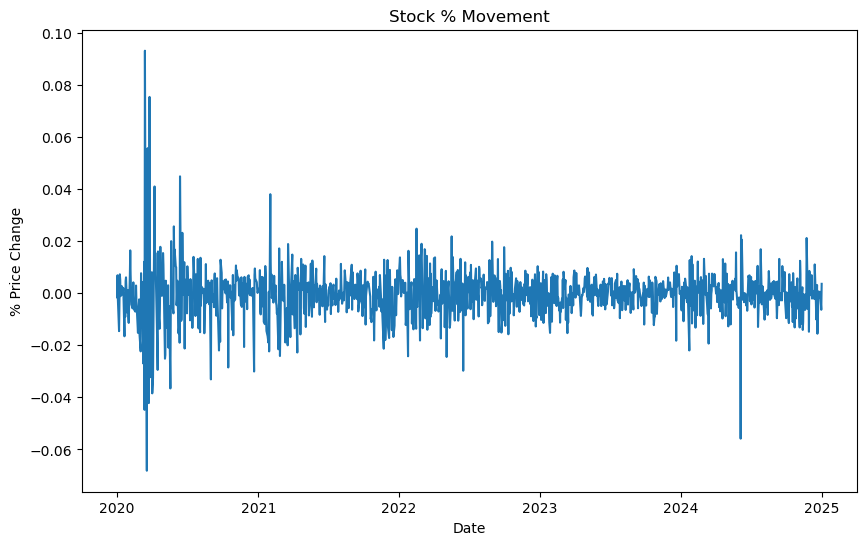

In [216]:
plt.figure(figsize = (10,6))
plt.plot((NSE_info['Close'] - NSE_info['Open'])/ NSE_info['Open'])
plt.title('Stock % Movement')
plt.xlabel('Date')
plt.ylabel('% Price Change')
plt.show()

In [263]:
df = pd.DataFrame(NSE_info)
df['% price change'] = ((df['Close'] - df['Open']) /df['Open']) * 100

In [226]:
n = [7, 14, 30, 50, 100]
df = rolling_standard_deviation(df, n)
df = moving_averages(df, n)
df = df.dropna()

In [227]:
df['SD-blend'] = df[[f'SD-{i}' for i in n]].median(axis=1)

In [228]:
df['%_price_change_next_day'] = df['% price change'].shift(-1)
df = df.dropna()

## Regression Problem

In [287]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [235]:
regression_df = df.copy()

In [275]:
regression_X = regression_df.drop(columns = ['%_price_change_next_day'])
regression_Y = regression_df['%_price_change_next_day']

In [276]:
regression_X

Price,Close,High,Low,Open,Volume,% price change,SD-7,SD-14,SD-30,SD-50,...,SD-14 / SD-100,SD-30 / SD-50,SD-30 / SD-100,SD-50 / SD-100,MA-7,MA-14,MA-30,MA-50,MA-100,SD-blend
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-29,9580.299805,9598.849609,9376.900391,9422.200195,967000,1.677948,1.250667,1.676925,1.474898,2.891250,...,0.775113,0.510125,0.681732,1.336403,9232.349888,9173.407017,9229.438281,8985.995957,10429.833994,1.676925
2020-06-01,9826.150391,9931.599609,9706.950195,9726.849609,794200,1.020894,1.168734,1.676392,1.455306,2.560573,...,0.773615,0.568352,0.671589,1.181644,9340.864258,9215.332031,9257.216634,8983.414961,10406.270498,1.676392
2020-06-02,9979.099609,9995.599609,9824.049805,9880.849609,770200,0.994348,1.145188,1.695733,1.466858,2.505902,...,0.782002,0.585361,0.676454,1.155619,9465.557059,9271.228446,9280.961621,8999.048945,10383.239492,1.695733
2020-06-03,10061.549805,10176.200195,10035.549805,10108.299805,794700,-0.462491,1.172735,1.589025,1.448801,2.461384,...,0.732743,0.588612,0.668082,1.135012,9611.599888,9319.657017,9307.618294,9020.938945,10361.588486,1.589025
2020-06-04,10029.099609,10123.849609,9944.250000,10054.250000,775100,-0.250147,1.057902,1.571033,1.447882,2.262152,...,0.725696,0.640046,0.668810,1.044940,9754.464146,9382.967704,9342.539941,9052.144941,10341.948984,1.571033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,23753.449219,23869.550781,23647.199219,23738.199219,189800,0.064242,0.872293,0.646446,0.779712,0.762577,...,0.986151,1.022469,1.189447,1.163309,24180.578404,24395.517857,24150.038411,24300.868047,24675.919004,0.762577
2024-12-24,23727.650391,23867.650391,23685.150391,23769.099609,177700,-0.174383,0.642493,0.646419,0.779436,0.762524,...,0.987652,1.022179,1.190887,1.165047,24031.914062,24342.675084,24136.020117,24276.136055,24663.684004,0.654500


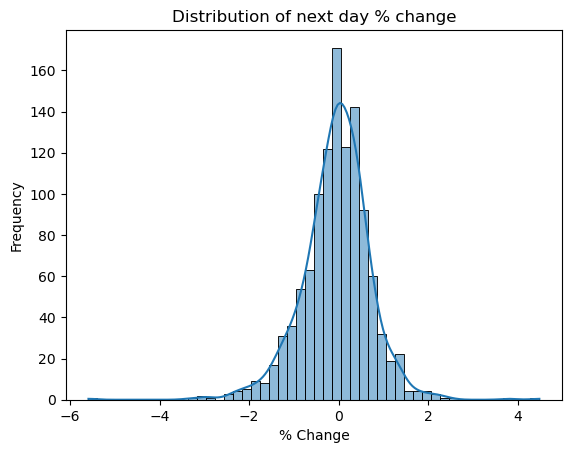

In [289]:
sns.histplot(regression_Y, bins = 50, kde=True)
plt.title("Distribution of next day % change")
plt.xlabel("% Change")
plt.ylabel("Frequency")
plt.show()

In [273]:
regression_Y.kurt()


4.629349566280901

In [272]:
regression_Y.skew()

-0.3995217694877233

In [282]:
X_train, X_test, y_train, y_test = train_test_split(regression_X, regression_Y, test_size = 0.15, shuffle = False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [291]:
print(X_train_scaled.shape, X_test_scaled.shape)

(966, 27) (171, 27)


In [294]:
models = {
    'Linear Regression' : LinearRegression(),
    'Random_Forest' :RandomForestRegressor(
        n_estimators = 200,
        max_depth = 10,
        random_state = 42,
        n_jobs = 1
        ),
    'XG Boost' : XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

Linear Regression is training

Linear Regression Results
RMSE: 0.8064
MAE:  0.5541
R²:   -0.0483


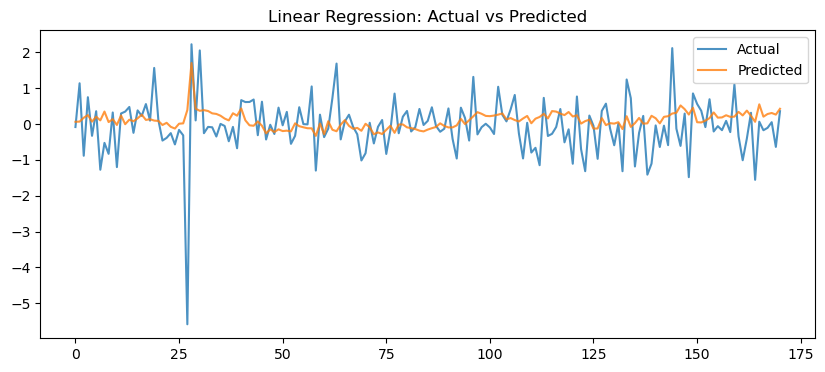

Linear Regression training is done




Random_Forest is training

Random_Forest Results
RMSE: 0.7913
MAE:  0.5441
R²:   -0.0092


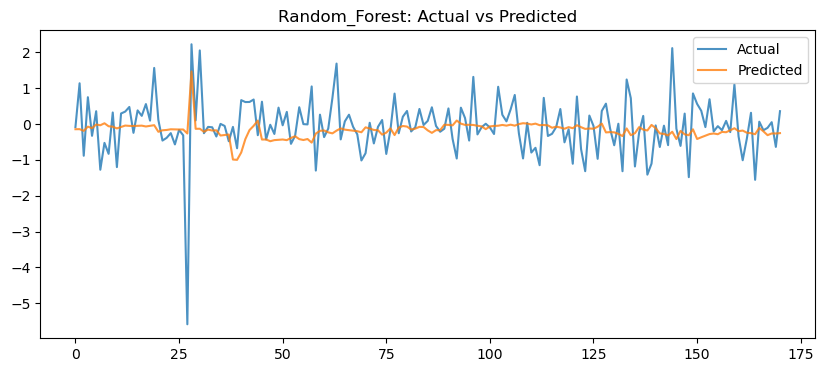

Random_Forest training is done




XG Boost is training

XG Boost Results
RMSE: 0.9380
MAE:  0.7266
R²:   -0.4183


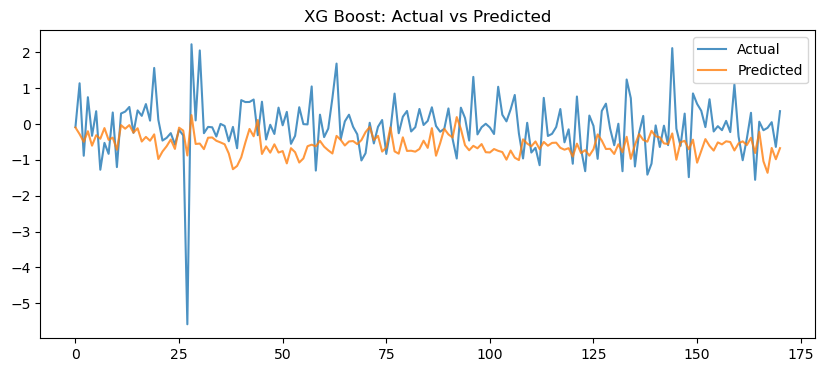

XG Boost training is done






In [297]:
results = {}
for name, model in models.items():
    print(f"{name} is training")
    results[name] = evaluate_regression_models(name, model, X_train, y_train, X_test, y_test)
    print(f"{name} training is done")
    print("\n\n\n")

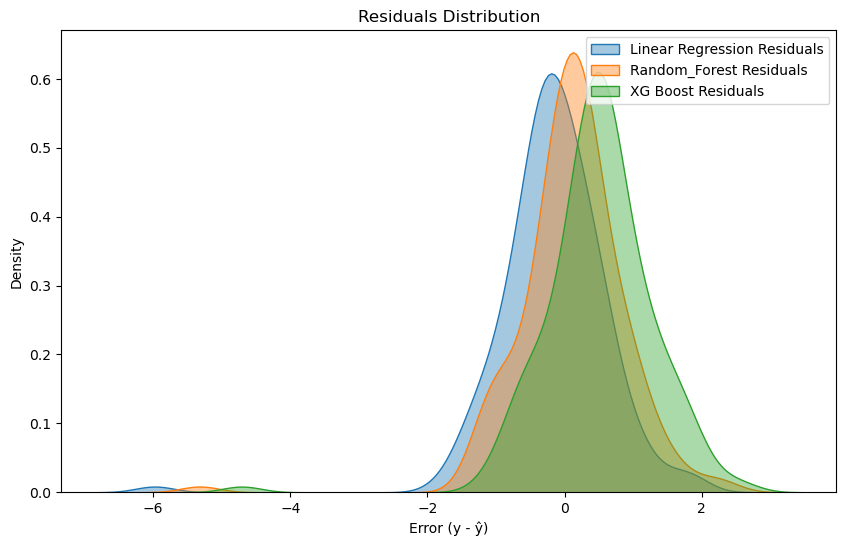

In [298]:
plt.figure(figsize=(10,6))
for name, preds in results.items():
    sns.kdeplot(y_test.values - preds, label=f"{name} Residuals", fill=True, alpha=0.4)

plt.title("Residuals Distribution")
plt.xlabel("Error (y - ŷ)")
plt.legend()
plt.show()

### Classification Problem

In [229]:
classification_df = classify_df(df)

In [234]:
classification_df['label'].value_counts()

label
Normal Bull    545
Normal Bear    533
Strong Bear     40
Strong Bull     19
Name: count, dtype: int64

Price,Close,High,Low,Open,Volume,% price change,SD-7,SD-14,SD-30,SD-50,...,SD-30 / SD-50,SD-30 / SD-100,SD-50 / SD-100,MA-7,MA-14,MA-30,MA-50,MA-100,SD-blend,%_price_change_next_day
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-29,9580.299805,9598.849609,9376.900391,9422.200195,967000,1.677948,1.250667,1.676925,1.474898,2.891250,...,0.510125,0.681732,1.336403,9232.349888,9173.407017,9229.438281,8985.995957,10429.833994,1.676925,1.020894
2020-06-01,9826.150391,9931.599609,9706.950195,9726.849609,794200,1.020894,1.168734,1.676392,1.455306,2.560573,...,0.568352,0.671589,1.181644,9340.864258,9215.332031,9257.216634,8983.414961,10406.270498,1.676392,0.994348
2020-06-02,9979.099609,9995.599609,9824.049805,9880.849609,770200,0.994348,1.145188,1.695733,1.466858,2.505902,...,0.585361,0.676454,1.155619,9465.557059,9271.228446,9280.961621,8999.048945,10383.239492,1.695733,-0.462491
2020-06-03,10061.549805,10176.200195,10035.549805,10108.299805,794700,-0.462491,1.172735,1.589025,1.448801,2.461384,...,0.588612,0.668082,1.135012,9611.599888,9319.657017,9307.618294,9020.938945,10361.588486,1.589025,-0.250147
2020-06-04,10029.099609,10123.849609,9944.250000,10054.250000,775100,-0.250147,1.057902,1.571033,1.447882,2.262152,...,0.640046,0.668810,1.044940,9754.464146,9382.967704,9342.539941,9052.144941,10341.948984,1.571033,0.479013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,23753.449219,23869.550781,23647.199219,23738.199219,189800,0.064242,0.872293,0.646446,0.779712,0.762577,...,1.022469,1.189447,1.163309,24180.578404,24395.517857,24150.038411,24300.868047,24675.919004,0.762577,-0.174383
2024-12-24,23727.650391,23867.650391,23685.150391,23769.099609,177700,-0.174383,0.642493,0.646419,0.779436,0.762524,...,1.022179,1.190887,1.165047,24031.914062,24342.675084,24136.020117,24276.136055,24663.684004,0.654500,-0.107679
